---
title: "Approximate Graph Symmetry Methods"
author: "Dávid Kubek"
format:
  html:
    toc: true
    code-fold: true
    code-summary: "Show the code"
    embed-resources: true
    smooth-scroll: true
---

# Continuous Methods for Approximate Graph Symmetries

This document provides a demonstration of the five optimization methods
implemented for the Master's thesis, "Using relaxation to compute approximate
symmetry of graphs."

The notebook is self-contained. It first generates a synthetic graph with a
known, built-in approximate symmetry and then runs each method to find this
symmetry. The results are visualized to allow for a direct comparison of their
performance on this controlled example.


## 1. Setup and Imports

First, we import the necessary libraries for data manipulation and
visualization, as well as the five implemented solution methods from the `AGS`
package.

In [18]:
# | label: setup
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import random as sparse_random

import random

# Import the implemented methods
from AGS.methods import (
    QSA,
    SymmetricApproximator,
    InteriorPoint,
    Manifold,
    OrthogonalRelaxation,
    DimensionalityReduction,
)

# Set a consistent style for plots
sns.set_theme(style="white", context="notebook")

# Turn on logging including debug information
import logging

logging.basicConfig(level=logging.ERROR)

## 2. Synthetic Data Generation

For the sake of example, we create a synthetic LRM graph with a known, imperfect symmetry. 

In [19]:
# | label: generate-data


def generate_lrm_graph(
    n: int, p: float, q: float, k: int = 0, seed: int | None = None
) -> nx.Graph:
    """
    Generate a Lateral Random Model (LRM) graph with k-rewiring operations.

    The LRM consists of two coupled Erdős-Rényi graphs with controlled
    bilateral symmetry that can be disrupted through rewiring.

    Parameters
    ----------
    n : int
        Total number of vertices (must be even)
    p : float
        Intra-component edge probability (within each ER component)
    q : float
        Inter-component edge probability (between corresponding vertices)
    k : int
        Number of rewiring operations to perform
    seed : int, optional
        Random seed for reproducibility

    Returns
    -------
    G : nx.Graph
        The generated LRM graph with k rewirings applied

    Raises
    ------
    ValueError
        If n is not even or if probabilities are not in [0,1]
    """
    if n % 2 != 0:
        raise ValueError("Total number of vertices n must be even")
    if not (0 <= p <= 1) or not (0 <= q <= 1):
        raise ValueError("Probabilities p and q must be in [0,1]")

    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    n_half = n // 2

    # Step 1: Generate the first ER component G
    G_left = nx.erdos_renyi_graph(n_half, p, seed=seed)

    # Step 2: Create the complete LRM graph
    L = nx.Graph()

    # Add vertices for both components
    # Left component: vertices 0 to n_half-1
    # Right component: vertices n_half to n-1
    L.add_nodes_from(range(n))

    # Add edges from the left component
    for u, v in G_left.edges():
        L.add_edge(u, v)

    # Add edges for the right component (exact copy of left)
    for u, v in G_left.edges():
        L.add_edge(u + n_half, v + n_half)

    # Step 3: Add inter-component edges with probability q
    for i in range(n_half):
        if random.random() < q:
            L.add_edge(i, i + n_half)

    # Step 4: Apply k rewiring operations
    for _ in range(k):
        _rewire_once(L)

    return L


def _rewire_once(G: nx.Graph) -> None:
    """
    Perform a single rewiring operation on the graph.

    Removes a randomly selected edge and adds a new edge between
    two previously unconnected vertices.
    """
    if G.number_of_edges() == 0:
        return

    # Get list of edges and non-edges
    edges = list(G.edges())
    n = G.number_of_nodes()

    # Find all possible non-edges (vertex pairs without an edge)
    non_edges = []
    for u in range(n):
        for v in range(u + 1, n):
            if not G.has_edge(u, v):
                non_edges.append((u, v))

    if len(non_edges) == 0:
        # Graph is complete, cannot add new edges
        return

    # Remove a random edge
    edge_to_remove = random.choice(edges)
    G.remove_edge(*edge_to_remove)

    # Add a random non-edge
    edge_to_add = random.choice(non_edges)
    G.add_edge(*edge_to_add)

In [20]:
# Generate our graph
A_synthetic = nx.adjacency_matrix(generate_lrm_graph(100, 0.1, 0.1)).toarray()

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x73581caaf3b0>


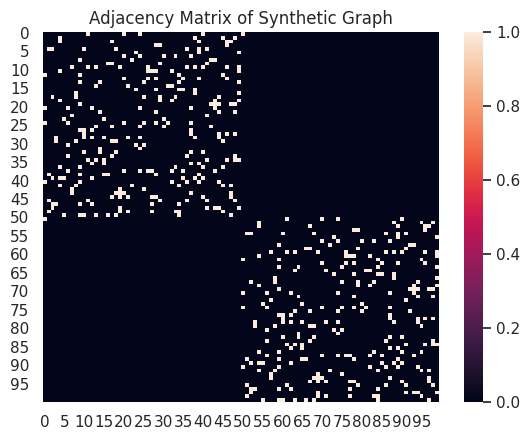

In [21]:
# Visualize the adjacency matrix
sns.heatmap(A_synthetic)
plt.title(f"Adjacency Matrix of Synthetic Graph")
plt.show()

The heatmap above shows the structure of our test graph. The two bright squares
on the diagonal represent the two nearly-identical subgraphs. The goal for our
algorithms is to find the permutation that swaps these two halves.

## 3. Running the Optimization Methods

We will now instantiate and run each of the five implemented methods on our
synthetic graph. For each method, we will use a set of default parameters known
to perform reasonably well. 

The output of the methods is the final output of the methods before being
projected to the DS manifold.

### 3.1. Quadratic Symmetry Approximator (QSA)

QSA is the first-order baseline method using the Frank-Wolfe algorithm.

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x73581caae120>


QSA completed in 0.02 seconds.


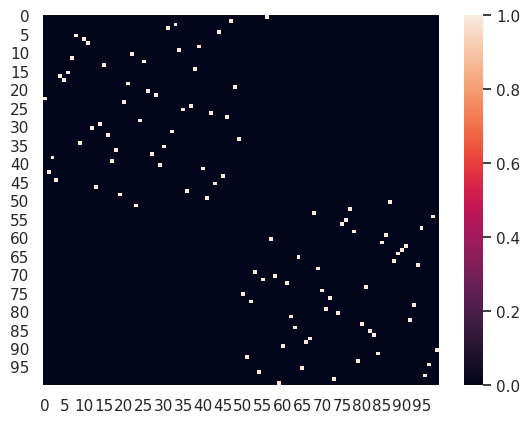

In [22]:
# | label: run-qsa
qsa_method = QSA(max_iter=500, verbose=0)
results_qsa = qsa_method.solve(A_synthetic, c=0.1)
P_qsa = results_qsa["P"]

print(f"QSA completed in {results_qsa['metrics']['time']:.2f} seconds.")

sns.heatmap(P_qsa)
plt.show()

### 3.2. Interior-Point Method (IP)

IP is a second-order method that uses the IPOPT solver. This method is powerful
but computationally more intensive.

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x73581ccf5dc0>


Interior-Point method completed in 1.90 seconds.


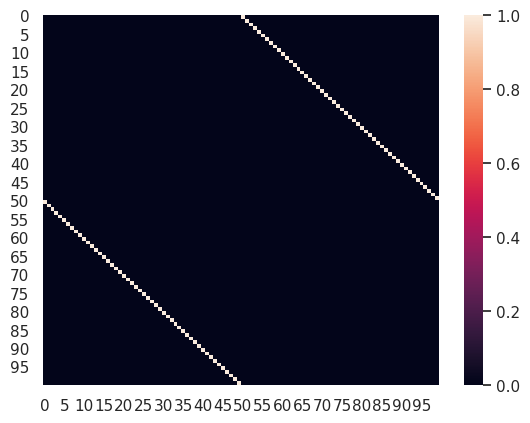

In [23]:
# | label: run-ip
ip_method = InteriorPoint(max_iter=500, verbose=0)
results_ip = ip_method.solve(A_synthetic, c=0.8)
P_ip = results_ip["P"]

print(
    f"Interior-Point method completed in {results_ip['metrics']['time']:.2f} seconds."
)

sns.heatmap(P_ip)
plt.show()

### 3.3. Manifold Optimization (MF)

MF is a geometry-aware method that performs optimization on the Doubly
Stochastic manifold.

Using cpu device
Optimizing...
 +++ Detected many consecutive TR- (radius decreases).
 +++ Consider decreasing options.Delta_bar by an order of magnitude.
 +++ Current values: Delta_bar = 100 and Delta0 = 12.5


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x73581cd495e0>


Terminated - max iterations reached after 76.86 seconds.

Manifold Optimization completed in 76.86 seconds.


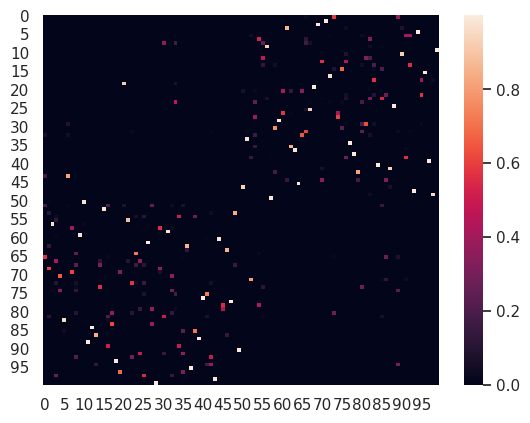

In [24]:
# | label: run-mf
mf_method = Manifold(optimizer="trust_regions", max_iter=500)
results_mf = mf_method.solve(A_synthetic, c=0.5)
P_mf = results_mf["P"]

print(
    f"Manifold Optimization completed in {results_mf['metrics']['time']:.2f} seconds."
)

sns.heatmap(P_mf)
plt.show()

### 3.4. Orthogonal Relaxation (OR)

OR uses an alternative relaxation space (the orthogonal group) and is
parameterized by temperature.

Using cpu device


Loss: 10.003708, Tau: 0.7000: 100%|██████████| 3000/3000 [00:35<00:00, 84.07it/s] 
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x73581c6fbb90>


Orthogonal Relaxation completed in 35.69 seconds.


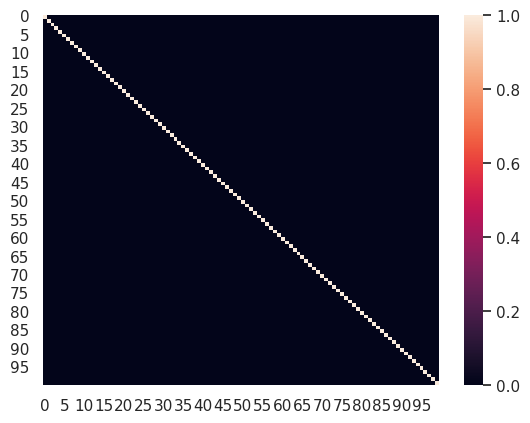

In [25]:
# | label: run-or
or_method = OrthogonalRelaxation(
    max_iter=3000, initial_tau=0.7, final_tau=None, loss="convex", verbose=1
)
results_or = or_method.solve(A_synthetic, c=0.1)
P_or = results_or["P"]

print(
    f"Orthogonal Relaxation completed in {results_or['metrics']['time']:.2f} seconds."
)

sns.heatmap(P_or)
plt.show()

### 3.5. Dimensionality Reduction (DR)

DR uses the `SoftSort` operator to reduce the optimization space to $O(n)$.

Using cpu device


Loss: 372.000000, Tau: 0.1000: 100%|██████████| 3000/3000 [00:05<00:00, 526.01it/s]
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x73581c57aa20>


Dimensionality Reduction completed in 5.70 seconds.


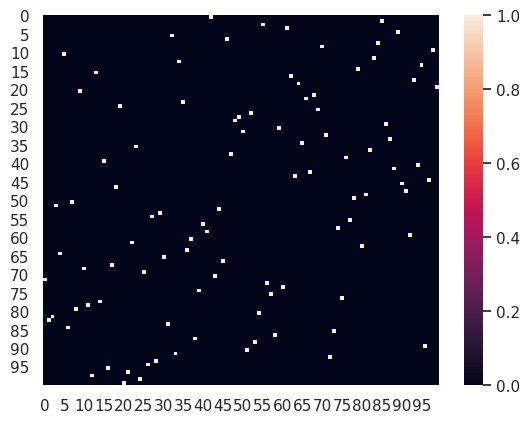

In [26]:
# | label: run-dr
dr_method = DimensionalityReduction(
    max_iter=3000,
    initial_tau=0.1,
    final_tau=None,  # Stronger relaxation performs better for DR
    loss="convex",
    verbose=1,
)
results_dr = dr_method.solve(A_synthetic, c=0.1)
P_dr = results_dr["P"]

print(
    f"Dimensionality Reduction completed in {results_dr['metrics']['time']:.2f} seconds."
)

sns.heatmap(P_dr)
plt.show()

## 3.5. SA (Symmetric Approximator) with Custom Objectives

The **SymmetricApproximator** (SA) class extends the Frank-Wolfe optimization approach
to support arbitrary differentiable objective functions. While the original QSA method
is specialized for the quadratic objective `-tr(APA^TP^T) + c·tr(P)` with closed-form
gradient and step size computations, SA uses PyTorch's automatic differentiation to
compute gradients for any user-defined objective.

In [27]:
# | label: setup-sa
# Using the default "nonconvex_relaxation" objective (same as original QSA)
sa_method = SymmetricApproximator(objective="nonconvex_relaxation", max_iter=500, verbose=1)

# Solve the approximate symmetry problem
sa_result = sa_method.solve(A_synthetic, c=0.1)
P_sa = sa_result["P"]

print(f"Final objective value: {sa_result['metrics']['final_loss']:.4f}")
print(f"Iterations: {sa_result['metrics']['iterations']}")

alpha=1.000, change=2.93e-01:   4%|▎         | 18/500 [00:00<00:00, 594.92it/s]

Final objective value: -265.0000
Iterations: 19


#### Comparing All Three Objective Functions

We can compare how different objective functions affect the optimization result:

[nonconvex_relaxation] iters=18, time=0.034s, loss=-312.0000
[dynamic_fixed_points] iters=179, time=0.256s, loss=0.0000
[frobenius_squared] iters=46, time=0.043s, loss=0.0000


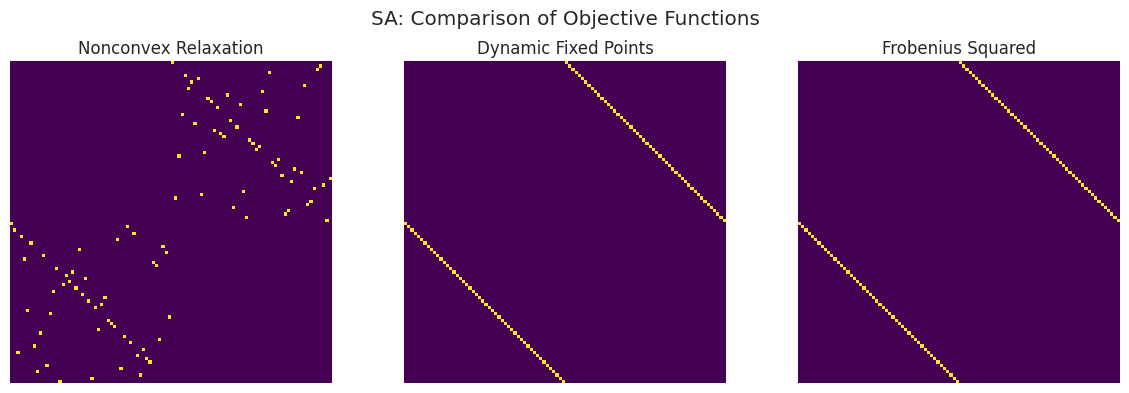

In [28]:
# | label: compare-sa-objectives
# Compare all three built-in objectives
objectives = ["nonconvex_relaxation", "dynamic_fixed_points", "frobenius_squared"]
sa_results = {}

for obj_name in objectives:
    solver = SymmetricApproximator(objective=obj_name, max_iter=500, verbose=0)
    result = solver.solve(A_synthetic, c=0.1)
    sa_results[obj_name] = result
    print(f"[{obj_name}] iters={result['metrics']['iterations']}, "
          f"time={result['metrics']['time']:.3f}s, loss={result['metrics']['final_loss']:.4f}")

# Visualize results side by side
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("SA: Comparison of Objective Functions")

for ax, obj_name in zip(axes, objectives):
    P = sa_results[obj_name]["P"]
    sns.heatmap(P, ax=ax, cbar=False, cmap="viridis", square=True)
    ax.set_title(obj_name.replace("_", " ").title())
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

#### Custom Objective Functions

Any PyTorch-compatible callable with signature `f(A, P, c) -> scalar` can be used:

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x73581c365070>


Custom objective completed in 0.97 seconds.
Final loss: 0.0016


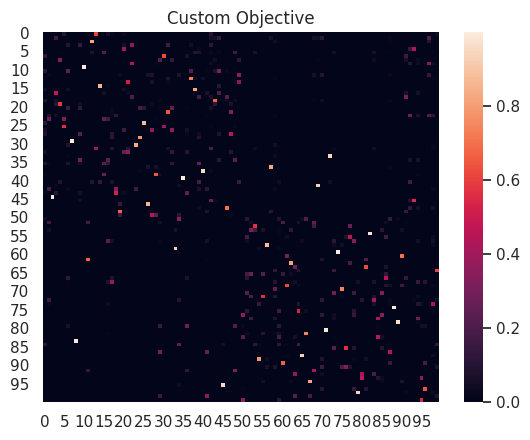

In [29]:
# | label: custom-objective-example
import torch

def dynamic_fixed_points(
    A: torch.Tensor, P: torch.Tensor, c: torch.Tensor
) -> torch.Tensor:
    """
    Dynamic fixed points objective: E / (n(n-1) - 2F(F-1)).

    Args:
        A: Adjacency matrix (n, n)
        P: Doubly-stochastic matrix (n, n)
        c: Penalty vector (unused, kept for interface consistency)

    Returns:
        Scalar loss value
    """
    n = A.shape[0]
    E = torch.norm(A - P @ A @ P.T, p="fro")
    F = torch.trace(P)

    # Denominator: effective non-fixed pairs
    denominator = n * (n - 1) - 2 * F * (F - 1) + 1e-8

    return E / denominator

# Use the custom objective
solver_custom = SymmetricApproximator(objective=dynamic_fixed_points, max_iter=500, verbose=0)
result_custom = solver_custom.solve(A_synthetic, c=0.1)

print(f"Custom objective completed in {result_custom['metrics']['time']:.2f} seconds.")
print(f"Final loss: {result_custom['metrics']['final_loss']:.4f}")

sns.heatmap(result_custom["P"])
plt.title("Custom Objective")
plt.show()

#### QSA vs SA: Comparison

Both QSA and SA can optimize the same `nonconvex_relaxation` objective:
$-\text{tr}(APA^T P^T) + c \cdot \text{tr}(P)$

The key difference is:
- **QSA**: Uses analytical gradient and closed-form optimal step size (exploits quadratic structure)
- **SA**: Uses autograd for gradients and Armijo backtracking line search

We run 100 trials with different random initializations to compare convergence behavior:

In [30]:
# | label: qsa-vs-sa-comparison
from AGS.metrics import E, S
import pandas as pd

n_runs = 100
comparison_results = []

print("[INFO] Running QSA vs SA comparison (100 runs each)...")

for run_id in range(n_runs):
    seed = 42 + run_id
    
    # Original QSA
    qsa_solver = QSA(max_iter=500, verbose=0, rng=seed)
    qsa_result = qsa_solver.solve(A_synthetic, c=0.1)
    
    # SA with same objective
    sa_solver = SymmetricApproximator(
        objective="nonconvex_relaxation", 
        max_iter=500, 
        verbose=0, 
        rng=seed
    )
    sa_result = sa_solver.solve(A_synthetic, c=0.1)
    
    # Compute metrics
    comparison_results.append({
        "run": run_id + 1,
        "method": "QSA",
        "time": qsa_result["metrics"]["time"],
        "iterations": qsa_result["metrics"]["iterations"],
        "E": E(A_synthetic, qsa_result["P"]),
        "S": S(A_synthetic, qsa_result["P"]),
    })
    comparison_results.append({
        "run": run_id + 1,
        "method": "SA",
        "time": sa_result["metrics"]["time"],
        "iterations": sa_result["metrics"]["iterations"],
        "E": E(A_synthetic, sa_result["P"]),
        "S": S(A_synthetic, sa_result["P"]),
    })

df_comparison = pd.DataFrame(comparison_results)

# Summary statistics
print("\n[RESULTS] Summary Statistics:")
print("-" * 60)
summary = df_comparison.groupby("method").agg({
    "time": ["mean", "std"],
    "iterations": ["mean", "std"],
    "E": ["mean", "std"],
    "S": ["mean", "std"],
}).round(4)
print(summary)
print("\n[OK] Data collection complete")

[INFO] Running QSA vs SA comparison (100 runs each)...

[RESULTS] Summary Statistics:
------------------------------------------------------------
          time         iterations                   E                S       
          mean     std       mean       std      mean      std    mean    std
method                                                                       
QSA     0.0591  0.0954     109.94  184.3792  115.7783  19.7629  0.0468  0.008
SA      0.1654  0.3183     109.82  183.8256  229.0234  42.0745  0.0925  0.017

[OK] Data collection complete


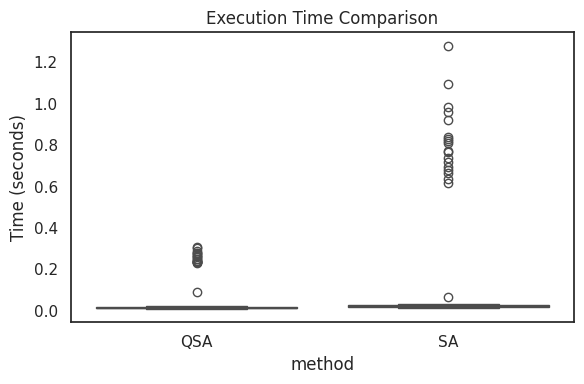

In [31]:
# | label: comparison-time-plot
# Execution time comparison
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=df_comparison, x="method", y="time", ax=ax)
ax.set_ylabel("Time (seconds)")
ax.set_title("Execution Time Comparison")
plt.tight_layout()
plt.show()

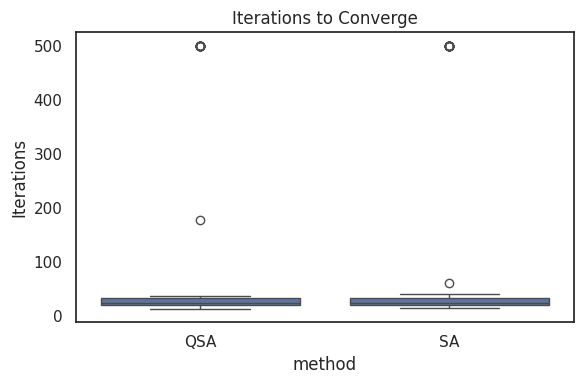

In [32]:
# | label: comparison-iterations-plot
# Iterations to converge comparison
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=df_comparison, x="method", y="iterations", ax=ax)
ax.set_ylabel("Iterations")
ax.set_title("Iterations to Converge")
plt.tight_layout()
plt.show()

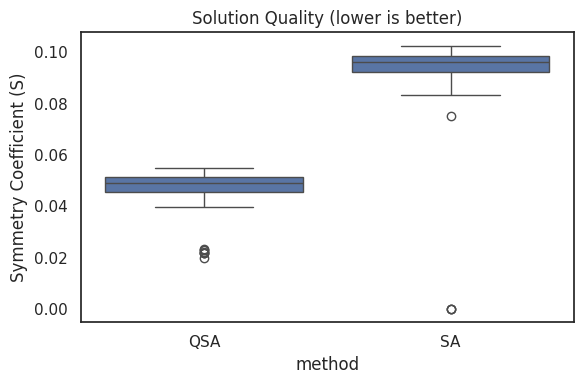

In [33]:
# | label: comparison-quality-plot
# Solution quality comparison (Symmetry Coefficient)
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=df_comparison, x="method", y="S", ax=ax)
ax.set_ylabel("Symmetry Coefficient (S)")
ax.set_title("Solution Quality (lower is better)")
plt.tight_layout()
plt.show()

## 4. Comparative Analysis of Results

Now, we visualize the resulting permutation matrices from all six methods
side-by-side. A perfect result would be a permutation swapping the two graph
halves.

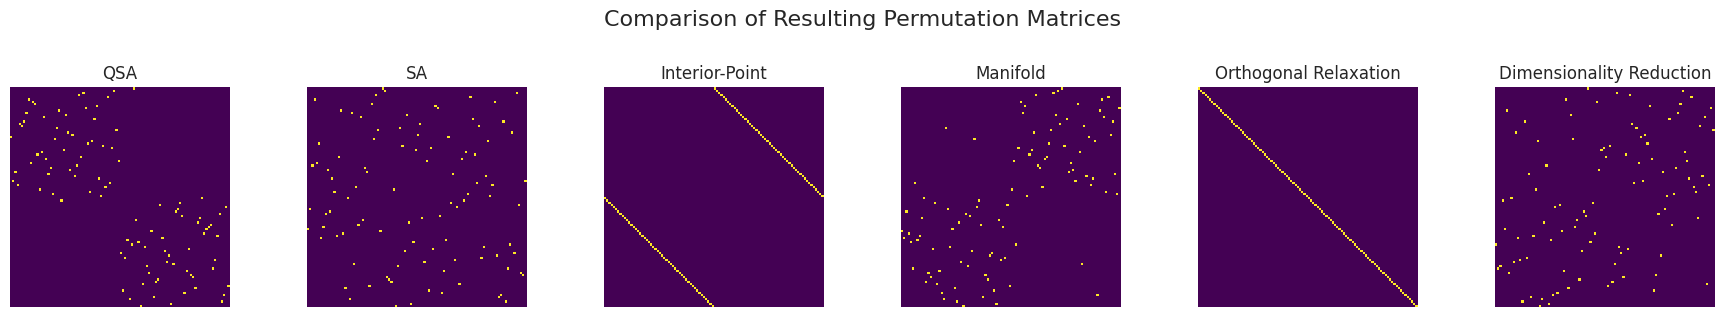

In [34]:
# | label: comparison-plot

# Collect results
methods = {
    "QSA": P_qsa,
    "SA": P_sa,
    "Interior-Point": P_ip,
    "Manifold": P_mf,
    "Orthogonal Relaxation": P_or,
    "Dimensionality Reduction": P_dr,
}

fig, axes = plt.subplots(1, 6, figsize=(18, 3))
fig.suptitle("Comparison of Resulting Permutation Matrices", fontsize=16, y=1.05)

for i, (name, P) in enumerate(methods.items()):
    # Project the doubly stochastic matrix to a hard permutation for clear visualization
    from scipy.optimize import linear_sum_assignment

    rows, cols = linear_sum_assignment(-P)
    P_hard = np.zeros_like(P)
    P_hard[rows, cols] = 1

    sns.heatmap(P_hard, ax=axes[i], cbar=False, cmap="viridis", square=True)
    axes[i].set_title(name)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()